# <center>Data Mining project: Discover and describe areas of interest<br> and events from geo-located parsed_data</center>

# 0/ Import Dataset and Libraries

## #1 Importing Libraries

- ### Installs

>requires: `pip install ipykernel`

In [ ]:

# installation of required libraries and dependencies
# numeric calculations
! pip install numpy==1.26.0 
# data frames 
! pip install pandas==2.1.1 
# machine learning algorithms 
! pip install scikit-learn==1.5.1 
# plotting 
! pip install matplotlib==3.8.0 
# Language processing
! pip install nltk
! python -m nltk.downloader popular # popular functions
# Folium
! pip install folium==0.12.1
# Geopandas
! pip install geopandas shapely 




- ###   Imports

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
import sklearn.cluster as cl
import folium
from folium.plugins import MarkerCluster
import random
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


c:\Users\Utilisateur\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Utilisateur\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## #2 Importing Data

In [3]:
# Charger les donn√©es avec low_memory=False pour √©viter les avertissements
DATA = pd.read_csv("data/flickr_data2.csv", sep=",", low_memory=False)
random.seed(42)

# I/ Understanding the Data

--Write something to describe this part of the report--

## #1 Data clearing and preparation

In [4]:
# Print details about parsing step:
# -> Number of lines parsed - % of original data parsed
def parse_conclusion(parsed_data):
    l = len(parsed_data)
    print(f"<Lines parsed: {l} - {round(100*l/len(DATA),3)}% of original data>")

- √âtape 1 : Nettoyage initial des colonnes

In [5]:
# Supprimer les espaces suppl√©mentaires dans les noms des colonnes
parsed_data = DATA
parsed_data.columns = parsed_data.columns.str.strip()

# Convertir les colonnes temporelles en num√©riques
# Liste des colonnes temporelles
time_columns = [
    'date_taken_minute', 'date_taken_hour', 'date_taken_day',
    'date_taken_month', 'date_taken_year',
    'date_upload_minute', 'date_upload_hour', 'date_upload_day',
    'date_upload_month', 'date_upload_year'
]

# Convertir chaque colonne en int64, remplacer les erreurs par 0
for col in time_columns:
    parsed_data[col] = pd.to_numeric(DATA[col], errors='coerce').fillna(0).astype('int64')

- √âtape 2 : Suppression des doublons bas√©s sur l'identifiant unique

In [6]:
# Sauvegarder les doublons pour audit futur
duplicate_data = parsed_data[parsed_data['id'].duplicated(keep='first')].sort_values("id")
duplicate_data.to_csv(
    "data/parsed_lines/duplicatedId.csv", index=False
)

# Supprimer les doublons
parsed_data = parsed_data[~parsed_data['id'].duplicated(keep='first')]

parse_conclusion(duplicate_data)

<Lines parsed: 252143 - 60.0% of original data>


- √âtape 3 : Gestion des colonnes inutilis√©es ou corrompues

In [7]:
# Identifier les colonnes inutiles
unused_columns = ["Unnamed: 16", "Unnamed: 17", "Unnamed: 18", 
                  "date_upload_minute", "date_upload_hour", "date_upload_day", 
                  "date_upload_month", "date_upload_year"]

# Sauvegarder les donn√©es corrompues
corrupted_data = parsed_data[parsed_data["Unnamed: 16"].notnull() | parsed_data["Unnamed: 17"].notnull() | parsed_data["Unnamed: 18"].notnull()]
corrupted_data.to_csv(
    "data/parsed_lines/corrupted_data.csv"
, index=False)


# Supprimer les colonnes inutilis√©es et les lignes corrompues
parsed_data = parsed_data[~(parsed_data["Unnamed: 16"].notnull() | parsed_data["Unnamed: 17"].notnull() | parsed_data["Unnamed: 18"].notnull())]
parsed_data = parsed_data.drop(columns=unused_columns)

parse_conclusion(corrupted_data)

<Lines parsed: 47 - 0.011% of original data>


- √âtape 4 : Nettoyage des coordonn√©es GPS exterieures √† Lyon

In [8]:
# D√©finir les limites g√©ographiques de Lyon
lyon_lat_min, lyon_lat_max = 45.69, 45.85
lyon_lon_min, lyon_lon_max = 4.78, 4.92

# Sauvegarder les donn√©es not Lyonnaises ou non definies
out_lyon_data = parsed_data[
    ~((parsed_data['lat'] >= lyon_lat_min) & 
    (parsed_data['lat'] <= lyon_lat_max) &
    (parsed_data['long'] >= lyon_lon_min) &
    (parsed_data['long'] <= lyon_lon_max))
]
out_lyon_data.to_csv(
    "data/parsed_lines/out_lyon.csv"
, index=False)

# Filtrer les donn√©es pour garder uniquement les points dans Lyon
parsed_data = parsed_data[
    (parsed_data['lat'] >= lyon_lat_min) & 
    (parsed_data['lat'] <= lyon_lat_max) &
    (parsed_data['long'] >= lyon_lon_min) &
    (parsed_data['long'] <= lyon_lon_max)
]

parse_conclusion(out_lyon_data)

<Lines parsed: 10502 - 2.499% of original data>


- √âtape 5 : Gestion des valeurs manquantes

In [9]:
# Supprimer les lignes avec des valeurs manquantes
#parsed_data = parsed_data.dropna(subset=['id', 'user', 'lat', 'long', 'tags', 'title', 'date_taken_minute', 'date_taken_hour', 'date_taken_day', 'date_taken_month', 'date_taken_year'])

# Sauvegarder les lignes √† donn√©es manquantes
val_manquante_data = parsed_data[parsed_data.drop(columns=['tags','title']).isna().any(axis = 1)]
val_manquante_data.to_csv(
    "data/parsed_lines/NaNs.csv"
, index=False)

# Remplir les valeurs manquantes pour les colonnes textuelles par des cha√Ænes vides
parsed_data['tags'] = parsed_data['tags'].fillna('')
parsed_data['title'] = parsed_data['title'].fillna('')

parse_conclusion(val_manquante_data)

<Lines parsed: 0 - 0.0% of original data>


- √âtape 6 : Filtrage des dates incoh√©rentes

In [10]:
min_year = 2009

# Sauvegarder les donn√©es ayant des date non correcte
uncorrect_date_data = parsed_data[
    ~((parsed_data['date_taken_year'] >= min_year) & (parsed_data['date_taken_year'] <= 2025) &
    (parsed_data['date_taken_month'] >= 1) & (parsed_data['date_taken_month'] <= 12) &
    (parsed_data['date_taken_day'] >= 1) & (parsed_data['date_taken_day'] <= 31) &
    (parsed_data['date_taken_hour'] >= 0) & (parsed_data['date_taken_hour'] <= 23) &
    (parsed_data['date_taken_minute'] >= 0) & (parsed_data['date_taken_minute'] <= 59))
]
uncorrect_date_data.to_csv(
    "data/parsed_lines/uncorrect_date.csv"
, index=False)

# Garder uniquement les dates raisonnables (entre 2009 et 2025)
parsed_data = parsed_data[
    (parsed_data['date_taken_year'] >= min_year) & (parsed_data['date_taken_year'] <= 2025) &
    (parsed_data['date_taken_month'] >= 1) & (parsed_data['date_taken_month'] <= 12) &
    (parsed_data['date_taken_day'] >= 1) & (parsed_data['date_taken_day'] <= 31) &
    (parsed_data['date_taken_hour'] >= 0) & (parsed_data['date_taken_hour'] <= 23) &
    (parsed_data['date_taken_minute'] >= 0) & (parsed_data['date_taken_minute'] <= 59) 
]

parse_conclusion(uncorrect_date_data)

<Lines parsed: 2028 - 0.483% of original data>


- √âtape 7 : Nettoyage/Standarisation des colonnes textuelles

In [11]:
# Fonction pour nettoyer le texte
def clean_text(text):
    # Supprimer les caract√®res sp√©ciaux et passer en minuscules
    return re.sub(r'[^a-zA-Z0-9, ]', '', text).lower()

# Appliquer le nettoyage sur les colonnes textuelles
parsed_data['tags'] = parsed_data['tags'].apply(clean_text)
parsed_data['title'] = parsed_data['title'].apply(clean_text)

# V√©rifier les r√©sultats
# parsed_data.head()

- √âtape 8 : Ajout de la colonne temps_diff (sec). <br><br> Correspond √† la diff√©rence en secondes entre l'ann√©e 2005 pile (0s,0min,...) et la date de prise de la photo. <br>Utile pour le clustering spatio-temporel.

In [122]:
print("minimum date: " + str(parsed_data['date_taken_year'].min())) 

# Create a datetime column from the given columns
dates = pd.to_datetime(
    {
        'year': parsed_data['date_taken_year'],
        'month': parsed_data['date_taken_month'],
        'day': parsed_data['date_taken_day']
    }
) + pd.to_timedelta(parsed_data['date_taken_minute'], unit='m') + pd.to_timedelta(parsed_data['date_taken_hour'], unit='h')

# Calculate difference from 1970-01-01 in seconds
parsed_data['temps_diff'] = (dates - pd.Timestamp('2005-01-01')).dt.total_seconds()

# V√©rifier les r√©sultats
# parsed_data.head()

minimum date: 2009


- √âtape 9 : Standardization.

In [123]:
from sklearn.preprocessing import StandardScaler

# Appliquer la standardisation
scaler = StandardScaler()
parsed_data[["lat_std","long_std","temps_diff"]] = scaler.fit_transform(parsed_data[["lat", "long","temps_diff"]])

# V√©rifier les r√©sultats
# parsed_data.head()

- R√©sultat final

In [124]:
# R√©sum√© final des donn√©es nettoy√©es
print("Donn√©es nettoy√©es :")

# R√©indexer les donn√©es
parsed_data = parsed_data.reset_index(drop=True)


# Sauvegarder les donn√©es nettoy√©es pour les prochaines √©tapes
parsed_data.to_csv("data/cleaned_flickr_data.csv", index=False)

parsed_data.head(5)

Donn√©es nettoy√©es :


id          user        lat      long  \
0  4395181099  30624617@N03  45.754858  4.821710   
1  4394748717  35853470@N00  45.753270  4.862953   
2  4394694699  11817998@N05  45.760655  4.846564   
3  4394803790  11545749@N06  45.784000  4.874072   
4  4394803554  11545749@N06  45.784000  4.874072   

                                                tags  \
0                   chair,lyon,rhne,chaise,rhnealpes   
1                                                      
2                                         365,iphone   
3       nin,nineinchnails,gift,screening,toiou,avott   
4  lyon,nin,nineinchnails,gift,screening,toiou,avott   

                       title  date_taken_minute  date_taken_hour  \
0           chaises avec vue                 11               15   
1                                            51               17   
2       59365  r46 v103 b163                 29               17   
3  20100129 toiou avott lyon                 15               20   
4  20100128 toiou avott lyon                 10               20   

   date_taken_day  date_taken_month  date_taken_year  temps_diff   lat_std  \
0              28                 2             2010   -1.579992 -0.537487   
1              28                 2             2010   -1.579883 -0.594232   
2              28                 2             2010   -1.579898 -0.330337   
3              28                 1             2010   -1.610235  0.503871   
4              28                 1             2010   -1.610238  0.503871   

   long_std  cluster_DBSCAN  cluster_DBSCAN_st  
0 -0.807554              -1                 -1  
1  1.519000              -1                 -1  
2  0.594482              -1                 -1  
3  2.146232              -1                 -1  
4  2.146232              -1                 -1

## #2 Visualize Data on map

In [ ]:
# Define the center of Lyon
lyon_lat, lyon_lon = 45.75, 4.85  # Approximate coordinates for Lyon, France

# Create a Folium map
map_lyon = folium.Map(location=[lyon_lat, lyon_lon], zoom_start=12)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(map_lyon)

# Add points from the dataset
for _, row in parsed_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],  # Replace with 'lat' and 'long' if necessary
        popup=f"Tags: {row['tags']}, Title: {row['title']}",  # Optional popup information
    ).add_to(marker_cluster)

# Display the map
map_lyon

# Optional: Save the map as an HTML file
map_lyon.save("lyon_map_unclustered.html")

## #3 Clustering data

To cluster the geo-located data from Lyon, we will apply multiple clustering techniques to identify areas of interest and patterns of activity.

Our aim is to :

- Identify dense regions of photo-taking activity, which may correspond to points of interest (e.g., landmarks, parks).
- Highlight outliers or isolated points that may not belong to any significant cluster.
- Compare different clustering techniques to determine the most effective one for this dataset.

### Setup:

In [189]:
clustered_data = parsed_data
clustered_data_st = parsed_data
clustered_data_st["temps_diff"] /= 225

features_base = ["lat", "long"]
features_spatio_temp = ["lat_std", "long_std", "temps_diff"]
features_lat_lng = ["lat_std", "long_std"]
lyon_lat, lyon_lon = 45.75, 4.85

In [197]:
def create_folium_map(clusteredData, clusterInfoColumnName, sampleSize):
    map = folium.Map([lyon_lat, lyon_lon], zoom_start = 12, scrollWheelZoom = True) 
    icon_color = ["#" + ''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for i in range(clusteredData[clusterInfoColumnName].nunique())]
    for i,row in clusteredData.sample(sampleSize).iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['long']],
            radius=5,
            color=icon_color[int(row[clusterInfoColumnName]) - 1],
            fill_color=icon_color[int(row[clusterInfoColumnName]) - 1],
            fill=True,
            popup=
                #str(row[clusterInfoColumnName])+'\n'+ # Debug (show cluster number)
                row['title']
        ).add_to(map)

    map.save("data/Maps/"+clusterInfoColumnName+"_map.html")

### a) K-means

>Why? Suitable for finding spherical clusters in data.<br>
Input required: Number of clusters (k).<br>
Steps: Apply K-Means with varying values of k to find the optimal number of clusters using the elbow method.


- Finding K with the elbow method

k = 1 - WCSS = 311040.0000000033
k = 2 - WCSS = 193308.58304795827
k = 3 - WCSS = 92331.81699365056
k = 4 - WCSS = 72915.77657658418
k = 5 - WCSS = 54676.56567628355


/var/folders/02/pn6v6_p924397h_95y6dszsw0000gn/T/ipykernel_73239/919349804.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ks_df = pd.concat([ks_df, new_row], ignore_index=True)


k = 6 - WCSS = 45330.84961505438
k = 7 - WCSS = 41457.71398405377
k = 8 - WCSS = 31289.210982345547
k = 9 - WCSS = 27987.056336243502
k = 10 - WCSS = 25194.13156004726
k = 11 - WCSS = 22691.30183208875
k = 12 - WCSS = 22467.184989559843
k = 13 - WCSS = 20318.374571341672
k = 14 - WCSS = 19139.116054809332
k = 15 - WCSS = 18284.200626787224
k = 16 - WCSS = 15570.078093749216
k = 17 - WCSS = 14400.421083507936
k = 18 - WCSS = 13475.229597251535
k = 19 - WCSS = 12391.731748572265
k = 20 - WCSS = 12072.252506705157


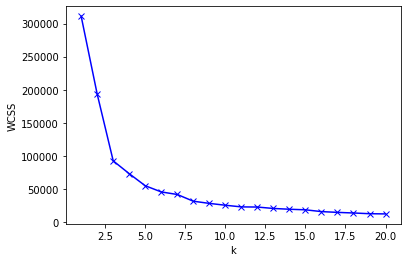

In [18]:
ks_df = pd.DataFrame(columns=["k", "WCSS"])
for k in range(1,21):
    kmeans = cl.KMeans(n_clusters=k, init='k-means++',random_state=42)
    kmeans.fit(clustered_data[features_lat_lng])
    print("k = " + str(k) + " - WCSS = " + str(kmeans.inertia_))
    new_row = pd.DataFrame({"k": [k], "WCSS": [kmeans.inertia_]})
    ks_df = pd.concat([ks_df, new_row], ignore_index=True)

plt.xlabel("k")
plt.ylabel("WCSS")
plt.plot(ks_df["k"], ks_df["WCSS"], "-xb")

We observe that the best k from the elbow method is k = 5

- Clustering data

In [19]:
# number of clusters 
k = 5 # set to optimal k found with elbow method
# create a model
kmeans = cl.KMeans(n_clusters=k, init='k-means++',random_state=42)
# fit scaled data
kmeans.fit(clustered_data[features_lat_lng])
# Add labels to data
K_mean_labels = kmeans.labels_
clustered_data = clustered_data.join(pd.DataFrame({"cluster_kmeans": K_mean_labels}))
clustered_data = clustered_data[clustered_data.cluster_kmeans != -1] # Takeout outliers

- Visualizing results

Sum of squared distances: 54676.56567628354


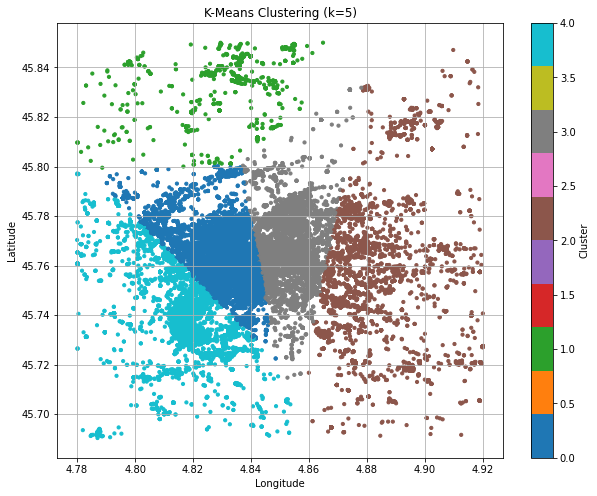

In [20]:
# Evaluate clustering
inertia = kmeans.inertia_
print(f"Sum of squared distances: {kmeans.inertia_}")

# sample_silhouette_values = silhouette_samples(clustered_data[features_base], K_mean_labels)
# means_lst = []
# for label in range(k):
#     means_lst.append(sample_silhouette_values[K_mean_labels == label].mean())

# Visualisation des clusters sur une carte simple
plt.figure(figsize=(10, 8))
plt.scatter(clustered_data['long'], clustered_data['lat'], c=clustered_data['cluster_kmeans'], cmap='tab10', s=10)
plt.title(f"K-Means Clustering (k={k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()


In [69]:
# Creation de la Map
create_folium_map(clustered_data, 'cluster_kmeans', 10000)

We can clearly see that the elbow method is insufficient to determine an optimal k given proximity.<br>
K means is also unoptimal given non globular clusters and proximity to each other.

### b) DBSCAN

### DBSCAN with only coordinates
- Finding Best EPS

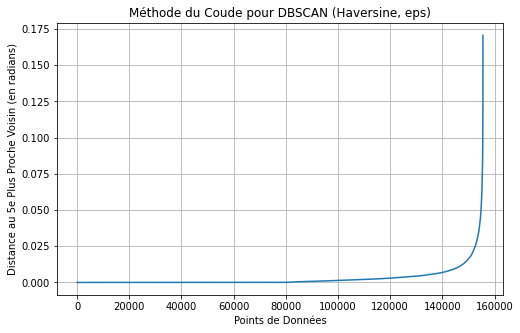

In [ ]:
# 2. Recherche du meilleur param√®tre `eps` avec la m√©thode du coude pour les k-plus proches voisins
# Trouver les distances au k-plus proche voisin (on prend k = 5)
nbrs = NearestNeighbors(n_neighbors=5, metric="euclidean").fit(clustered_data[features_lat_lng])
distances, indices = nbrs.kneighbors(clustered_data[features_lat_lng])

# Trier les distances pour identifier un coude
sorted_distances = np.sort(distances[:, -1])  # Distance au 5e plus proche voisin
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.title("M√©thode du Coude pour DBSCAN (Euclidean, eps)")
plt.xlabel("Points de Donn√©es")
plt.ylabel("Distance au 5e Plus Proche Voisin")
plt.grid()
plt.show()

La distance eps optimale est proche de 0.00005 rad. <br>
Or par l'exp√©rimentation nous avons trouv√© qu'elle est de 0.0000487.

La distance eps optimale est proche de 0.0125 rad. <br>
Or par l'exp√©rimentation nous avons trouv√© qu'elle est de 0.012175.

- Clustering Data

In [79]:
# 3. D√©finir un `eps` en fonction du coude observ√© (par exemple, eps=0.01)
# Note : eps est en radians, correspondant √† une distance angulaire (~6371 km * radians pour une distance en km)

# eps = 300 / 6371000
eps = 0.004
min_samples = 45

# Appliquer DBSCAN avec la m√©trique Haversine
dbscan = cl.DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
dbscan_labels = dbscan.fit_predict(clustered_data[features_lat_lng]) 

In [80]:
# 4. Ajouter les √©tiquettes aux donn√©es
clustered_data["cluster_DBSCAN"] = dbscan_labels

# Compter le nombre de clusters (ignorer les outliers marqu√©s comme -1)
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
num_outliers = sum(dbscan_labels == -1)
clustered_data = clustered_data[clustered_data.cluster_DBSCAN != -1] # Takeout outliers

- Visualizing results

Nombre de clusters d√©tect√©s : 335
Nombre d'outliers : 79532


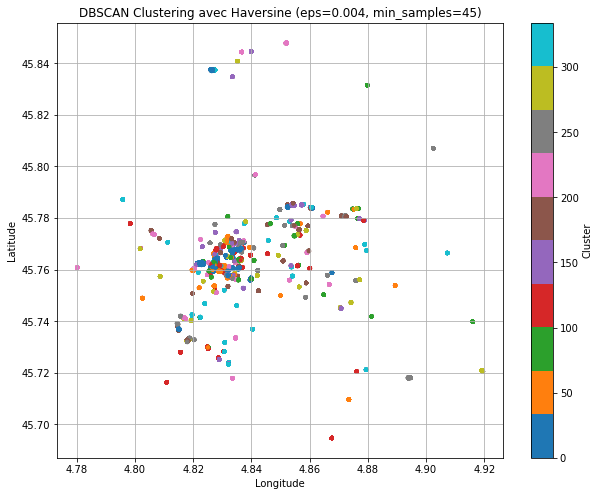

In [81]:
# 5. Visualisation des clusters
print(f"Nombre de clusters d√©tect√©s : {num_clusters}")
print(f"Nombre d'outliers : {num_outliers}")

plt.figure(figsize=(10, 8))
plt.scatter(
    clustered_data['long'], 
    clustered_data['lat'], 
    c=clustered_data['cluster_DBSCAN'], 
    cmap='tab10', 
    s=10
)
plt.title(f"DBSCAN Clustering avec Haversine (eps={eps}, min_samples={min_samples})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()

create_folium_map(clustered_data, 'cluster_DBSCAN', 30000)


### DBSCAN with coordinates and time
- Finding Best EPS

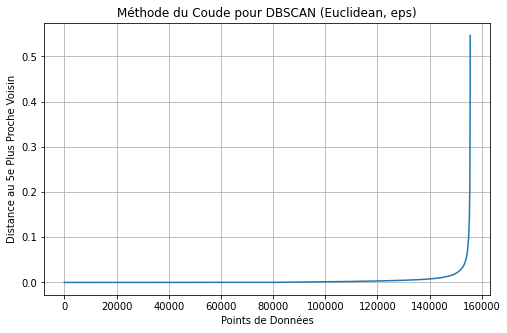

In [181]:
# 2. Recherche du meilleur param√®tre `eps` avec la m√©thode du coude pour les k-plus proches voisins
# Trouver les distances au k-plus proche voisin (on prend k = 5)
nbrs = NearestNeighbors(n_neighbors=5, metric="euclidean").fit(clustered_data_st[features_spatio_temp])
distances, indices = nbrs.kneighbors(clustered_data_st[features_spatio_temp])

# Trier les distances pour identifier un coude
sorted_distances = np.sort(distances[:, -1])  # Distance au 5e plus proche voisin
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.title("M√©thode du Coude pour DBSCAN (Euclidean, eps)")
plt.xlabel("Points de Donn√©es")
plt.ylabel("Distance au 5e Plus Proche Voisin")
plt.grid()
plt.show()

- Clustering Data

In [193]:
# 3. D√©finir un `eps` en fonction du coude observ√© (par exemple, eps=0.01)
# Note : eps est en radians, correspondant √† une distance angulaire (~6371 km * radians pour une distance en km)

# eps = 300 / 6371000
eps = 0.004
min_samples = 45

# Appliquer DBSCAN avec la m√©trique Euclidean
dbscan_st = cl.DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
dbscan_labels_st = dbscan_st.fit_predict(clustered_data_st[features_spatio_temp]) 

In [194]:
# 4. Ajouter les √©tiquettes aux donn√©es
clustered_data_st["cluster_DBSCAN_st"] = dbscan_labels_st

# Compter le nombre de clusters (ignorer les outliers marqu√©s comme -1)
num_clusters = len(set(dbscan_labels_st)) - (1 if -1 in dbscan_labels_st else 0)
num_outliers = sum(dbscan_labels_st == -1)
clustered_st = clustered_data_st[clustered_data_st.cluster_DBSCAN_st != -1] # Takeout outliers

- Visualizing results

Nombre de clusters d√©tect√©s : 335
Nombre d'outliers : 79532


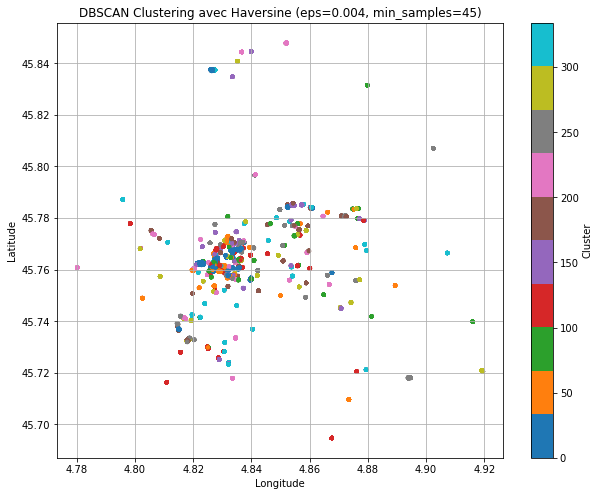

In [198]:
# 5. Visualisation des clusters
print(f"Nombre de clusters d√©tect√©s : {num_clusters}")
print(f"Nombre d'outliers : {num_outliers}")

plt.figure(figsize=(10, 8))
plt.scatter(
    clustered_st['long'], 
    clustered_st['lat'], 
    c=clustered_st['cluster_DBSCAN_st'], 
    cmap='tab10', 
    s=10
)
plt.title(f"DBSCAN Clustering avec Haversine (eps={eps}, min_samples={min_samples})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()

create_folium_map(clustered_st, 'cluster_DBSCAN_st', 30000)


### c) Hierarchical Clustering

>Why? Provides a dendrogram to visualize the hierarchy of clusters.<br>
Input required: No predefined number of clusters; can be adjusted by cutting the dendrogram.<br>
Steps: Compute a linkage matrix using ward or other linkage methods. Cut the dendrogram to form clusters.

In [1]:
# 1. Pr√©paration des donn√©es
# Sous-√©chantillonnage des donn√©es (garder n points al√©atoires pour √©viter les blocages)

geo_data_sampled = parsed_data.sample(n=10000, random_state=42)
geo_data_sampled.reset_index(drop=True)

# 2. Cr√©ation de la matrice de linkage avec les donn√©es √©chantillonn√©es
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

linkage_matrix = linkage(geo_data_sampled[features_base], method='ward')

# 3. Visualisation du dendrogramme
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Truncate pour simplifier la visualisation
plt.title("Dendrogramme (Clustering Hi√©rarchique - √âchantillonn√©)")
plt.xlabel("Points de donn√©es")
plt.ylabel("Distance")
plt.show()

# 4. D√©coupage du dendrogramme pour obtenir les clusters
num_clusters = 188  # Nombre de clusters √† obtenir
sampled_clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Ajouter les clusters √† l'√©chantillon pour analyse
geo_data_sampled['hierarchical_cluster'] = sampled_clusters

NameError: name 'parsed_data' is not defined

- Visualizing results

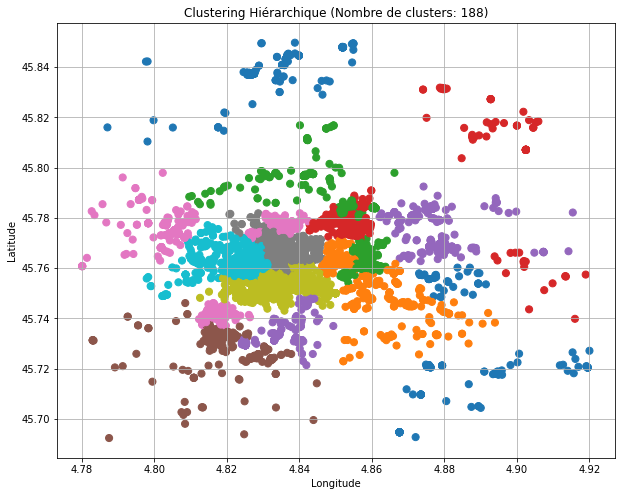

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(geo_data_sampled['long'], geo_data_sampled['lat'], c=geo_data_sampled['hierarchical_cluster'], cmap='tab10', s=50)
plt.title(f"Clustering Hi√©rarchique (Nombre de clusters: {num_clusters})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()
create_folium_map(geo_data_sampled, 'hierarchical_cluster', 10000)

## #4 post-processing

In [ ]:
post_processed_data = clustered_data
post_processed_data.head(1)

id          user        lat      long  \
9  4392367159  47924539@N05  45.762059  4.822654   

                                     tags     title  date_taken_minute  \
9  france,lyon,fourvire,lesphotosdevoyage  fourvire                 28   

   date_taken_hour  date_taken_day  date_taken_month  date_taken_year  \
9               12              27                 2             2010   

   temps_diff   lat_std  long_std  cluster_kmeans  cluster_DBSCAN  
9   -1.581085 -0.280167 -0.754302               0               4

### Filter groups where there isn't enough users: low number of samples or very few users withing the cluster.

In [ ]:
user_limit = 5
for cluster_i in range(post_processed_data["cluster_DBSCAN"].nunique()):
    cluster = post_processed_data[post_processed_data.cluster_DBSCAN == cluster_i]
    nbUsers = cluster["user"].nunique()
    if(nbUsers < user_limit):
        cluster.to_csv(
            "data/post_processing/insufficient_users_clusters/"+str(cluster_i)+".csv",
        index=False)
        post_processed_data = post_processed_data[~post_processed_data["id"].isin(cluster["id"])]
parse_conclusion(post_processed_data)

<Lines parsed: 56442 - 13.431% of original data>


## #5 Description of areas of interest using text pattern mining

In [ ]:
# T√©l√©charger les ressources de NLTK
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Charger les stopwords en fran√ßais et en anglais
stop_words = set(stopwords.words('french') + stopwords.words('english'))
lemmatizer = WordNetLemmatizer()



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saadelghissassi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saadelghissassi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saadelghissassi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def clean_text(text):
    """
    Nettoyer un texte :
    - Conversion en minuscules
    - Suppression des caract√®res sp√©ciaux
    - Tokenisation
    - Suppression des stopwords
    - Suppression des identifiants alphanum√©riques (ex: ddc4674)
    - Lemmatisation
    - Suppression des espaces inutiles
    """
    text = str(text).lower()  # Convertir en minuscules
    text = re.sub(r'\b[a-zA-Z]{2,4}\d+\b', '', text)  # Supprimer les identifiants alphanum√©riques (ex: "ddc4674")
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Supprimer les caract√®res sp√©ciaux mais garder les espaces
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer les espaces en double et au d√©but/fin
    words = word_tokenize(text)  # Tokenisation
    words = [word for word in words if word not in stop_words]  # Suppression des stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatisation
    return " ".join(words)


In [ ]:
# Nettoyage des titres et des tags
post_processed_data["title_clean"] = post_processed_data["title"].fillna("").apply(clean_text)
post_processed_data["tags_clean"] = post_processed_data["tags"].fillna("").apply(lambda x: clean_text(x.replace(",", " ")))


In [ ]:
# Ajouter une colonne combin√©e pour l'analyse
post_processed_data["text_clean"] = post_processed_data["title_clean"] + " " + post_processed_data["tags_clean"]

In [ ]:
# Associer les Clusters aux Textes
# D'abord, il faut fusionner les clusters DBSCAN (clustered_data) avec les titres et tags nettoy√©s (post_processed_data).

# Fusion sur la colonne "id"
df_clusters_texts = clustered_data.merge(post_processed_data, on="id", how="inner")

# Renommer les colonnes pour √©viter les doublons (cluster_DBSCAN_x et cluster_DBSCAN_y puisque
df_clusters_texts.rename(columns={"cluster_DBSCAN_x": "cluster_DBSCAN"}, inplace=True)
# Supprimer les colonnes inutiles (doublons)
df_clusters_texts.drop(columns=["cluster_DBSCAN_y"], errors="ignore", inplace=True)


In [ ]:
# On enregistre cluster_DBSCAN, lat, long, id et text_clean dans un CSV pour plus tard
# S√©lectionner uniquement les colonnes n√©cessaires
df_clusters_texts = post_processed_data[['id', 'lat', 'long', 'cluster_DBSCAN', 'text_clean']]

# Sauvegarder sous CSV pour l'application
df_clusters_texts.to_csv("df_clusters_texts.csv", index=False)

# V√©rifier le fichier cr√©√©
df_check = pd.read_csv("df_clusters_texts.csv")
print(df_check.head())  # V√©rifie que les colonnes sont bien pr√©sentes
print(df_check.columns)  # V√©rifie les noms de colonnes
print(df_check.isnull().sum())  # V√©rifie s'il y a des valeurs manquantes

print("‚úÖ Fichier df_clusters_texts.csv cr√©√© avec succ√®s !")


           id        lat      long  cluster_DBSCAN  \
0  4392367159  45.762059  4.822654               4   
1  4393122952  45.767328  4.833362               6   
2  4391929257  45.837545  4.826130               0   
3  4391929181  45.837545  4.826130               0   
4  4391929097  45.837545  4.826130               0   

                                          text_clean  
0    fourvire france lyon fourvire lesphotosdevoyage  
1                    lyon novembre lesphotosdevoyage  
2  vulcain monde felix portrait sculpture streeta...  
3  vulcain monde felix portrait sculpture streeta...  
4  vulcain monde felix portrait sculpture streeta...  
Index(['id', 'lat', 'long', 'cluster_DBSCAN', 'text_clean'], dtype='object')
id                0
lat               0
long              0
cluster_DBSCAN    0
text_clean        0
dtype: int64
‚úÖ Fichier df_clusters_texts.csv cr√©√© avec succ√®s !


In [ ]:
#ANALYSE DE LA FREQUENCE DES MOTS DANS CHAQUE CLUSTER

# Regrouper les textes de chaque cluster en une seule grande string
cluster_texts = df_clusters_texts.groupby("cluster_DBSCAN")["text_clean"].apply(lambda x: " ".join(x))

print(cluster_texts.head(5))

cluster_DBSCAN
0    vulcain monde felix portrait sculpture streeta...
1    passerelle rendezvous bridge lyon rhne pont so...
2    square lamp lamp dailypicture leffe beer glass...
4    fourvire france lyon fourvire lesphotosdevoyag...
5     lyon liquid lyon  lyon  lyon banana lyon scar...
Name: text_clean, dtype: object


**On continue le filtrage pour faire des analyses coh√©rentes par la suite.**

On exclut de nombreux mots non significatifs de l'analyse : 

In [ ]:
from collections import Counter

# √âtape 1 : D√©finir les mots √† exclure
excluded_words = {
    # Lieux g√©n√©raux et g√©ographie trop large
    "lyon", "france", "europe", "rhne", "rhnealpes", "auvergnerhnealpes", "francia", "frankrijk", "frankreich",
      "place", "urban", "ville", "quartier", "rgionlyonnaise",
    
    # Mots trop fr√©quents et g√©n√©riques
    "fr", "lione", "ville", "city", "urban", "travel",
    "photo", "photography", "flickr", "uploadedbyflickrmobile", "flickriosappfilternofilter",
    "onlylyon", "igerslyon", "followme", "instagood", "common", "old", "new", "people",
    "day", "summer", "night", "year", "time", "december", "open", "closed", "march", "feu","french", "juillet", "juin",
    
    # Mots de f√™tes et √©v√©nements
    "fte", "biennale", "biennaledelyon",
    "dec", "dcembre", "thdecember", "nuit", "illumination",
    
    # Technique photo et r√©seaux sociaux
    "mm", "f", "b", "p", "e", "dsc", "uploadedbyinstagram", "instagramapp", "square", "squareformat",
    "iphoneography", "jpg", "img", "picture", "foursquarevenue", "upload", "dc", "ec", "rise",
    "hudson", "xproii", "perpetua", "clarendon", "filter", "macro", "lens", "focale", "zoom", "bokeh", "flash",
    "blackandwhite", "noiretblanc", "bw", "bnw", "monochrome", "creativecommons",
    
    # Mat√©riel photo
    "eos", "tamronsp", "canon", "nikon", "fujifilmxt", "mmf", "sonyalpha", "ilce", "dmkii", "dailypicture",
    "sigma", "leica", "summicronr", "summicron", "leitz", "nikkor", "creative", "photomobile",
    
    # Politique et manifestations
    "manifestation", "retraites", "rforme", "partidegauche", "frontdegauche", "ermai",
    "giletsjaunes", "protest", "demonstration", "justice", "palaisdejustice",
    
    # Transports
    "funiculaire", "metro", "transport", "bus", "station", "railway",
    
    
    # Noms propres peu informatifs
    "fb", "bf", "aa", "fe", "os", "bij", "ea", "fde", "ecb", "bca", "abf", "fbfeac", "visiosfeir",
    "arnalphotography", "arnallephotography", "arnaudbouvard", "capturedalive", "jaredleto",
    "shannonleto", "metallica", "martingore", "davegahan", "touroftheuniverse", "dmtotu",
    
    # √âl√©ments sp√©cifiques mais non significatifs
    "citt", "citta", "feste", "festa", "delle", "evento", "thtf", "adelsa", "summicronr",
    "installation", "graff", "tag", "sticker", "zombie", "walk", "revolution", "graffs",
    
    # Autres termes techniques et hashtags
    "instapic", "instagram", "igers", "pic", "like", "follow", "igersart", "paris", "wwwmonsieurbidulenet",
    "cest", "wwwsylvainmestrecom", "photographie", "black", "white", "photographe",
    
    # Abr√©viations et termes courts non significatifs
    "cc", "gr", "wp", "pro", "db", "ov", "dxopl", "ae", "th", "st", "bnw", "bw", "nb", "dscn", 
    "fp", "igp", "lfl", "ubb", "lou", "er", "rf", "ptdo", "fdl", "sx", "xphotographer", "bnw", 
    "wm", "cnv", "bda", "mearrondissement", "earrondissement", "lyonpresqule", "oneshot", "lyj", 
    "lyr", "accr√©ditation", "leeloo", "capphi", "heho", "mateo", "pelussin", "jossarisfoto", 
    "panasoniclumixdmcfz", "thierryhermann", "ddc",
}




# √âtape 2 : Fonction pour compter les mots qui reviennent le plus
def count_filtered_words(text):
    words = text.split()
    words = [word for word in words if word not in excluded_words]  # Filtrer
    return Counter(words)

# √âtape 3 : Appliquer sur chaque cluster
filtered_word_counts_per_cluster = cluster_texts.apply(count_filtered_words)

# √âtape 4 : Afficher les 10 mots les plus fr√©quents par cluster
for cluster, word_counts in filtered_word_counts_per_cluster.items():
    print(f"üîπ Cluster {cluster} - Top 10 mots :")
    print(word_counts.most_common(10))  # Top 10 mots du cluster
    print("-" * 50)  # Ligne de s√©paration


üîπ Cluster 0 - Top 10 mots :
[('chaos', 15157), ('demeureduchaos', 12634), ('abodeofchaos', 12542), ('thierryehrmann', 12263), ('alchemy', 11983), ('portrait', 11933), ('prophecy', 11711), ('contemporaryart', 11687), ('secret', 11622), ('organmuseum', 11606)]
--------------------------------------------------
üîπ Cluster 1 - Top 10 mots :
[('hteldieu', 7), ('bergesdurhne', 6), ('january', 5), ('iphone', 5), ('carolechevallet', 5), ('cacolebn', 5), ('hipstamatic', 5), ('quaisdurhne', 5), ('water', 4), ('ktm', 4)]
--------------------------------------------------
üîπ Cluster 2 - Top 10 mots :
[('vieux', 6), ('duck', 5), ('bird', 4), ('apartment', 4), ('lamp', 2), ('leffe', 2), ('beer', 2), ('barman', 2), ('portrait', 2), ('akroche', 2)]
--------------------------------------------------
üîπ Cluster 4 - Top 10 mots :
[('fourvire', 2326), ('basilique', 1451), ('basilica', 759), ('fourviere', 718), ('notredame', 716), ('church', 583), ('dame', 573), ('frana', 272), ('architecture', 27

**On applique maintenant TF-IDF sur les clusters filtr√©s**
TF-IDF r√©duit l'importance des mots fr√©quents dans plusieurs clusters et met en valeur ceux qui sont plus sp√©cifiques √† certains clusters.

In [ ]:
# üîπ √âtape 1 : Transformer les donn√©es pour TF-IDF
cluster_texts_filtered = {cluster: " ".join(words.elements()) for cluster, words in filtered_word_counts_per_cluster.items()}

# üîπ √âtape 2 : Appliquer TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(cluster_texts_filtered.values())

# üîπ √âtape 3 : R√©cup√©rer les mots et scores
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=cluster_texts_filtered.keys(), columns=feature_names)

# üîπ √âtape 4 : Stocker tous les mots avec leurs scores pour chaque cluster
top_keywords_per_cluster = {
    cluster: list(zip(df_tfidf.loc[cluster].index, df_tfidf.loc[cluster].values))  # Stocker tous les mots
    for cluster in df_tfidf.index
}

# üîπ √âtape 5 : Affichage des 10 mots les plus pertinents par cluster
for cluster, keywords in top_keywords_per_cluster.items():
    top_10 = sorted(keywords, key=lambda x: x[1], reverse=True)[:10]  # Trier et r√©cup√©rer top 10
    print(f"\nüîπ Cluster {cluster} - TOP 10 Mots-cl√©s TF-IDF avec scores :")
    for word, score in top_10:
        print(f"   - {word}: {score:.4f}")  # Affichage avec 4 d√©cimales
    print("-" * 50)

# üîπ √âtape 6 : Stocker tous les r√©sultats sous forme de dataframe pour r√©utilisation
df_tfidf_long = df_tfidf.stack().reset_index()
df_tfidf_long.columns = ['Cluster', 'Word', 'TF-IDF Score']

# üîπ Sauvegarde des r√©sultats en CSV pour une r√©utilisation plus tard
df_tfidf_long.to_csv("tfidf_results.csv", index=False)





üîπ Cluster 0 - TOP 10 Mots-cl√©s TF-IDF avec scores :
   - chaos: 0.2206
   - demeureduchaos: 0.1839
   - abodeofchaos: 0.1825
   - thierryehrmann: 0.1785
   - alchemy: 0.1744
   - prophecy: 0.1705
   - organmuseum: 0.1689
   - mystery: 0.1685
   - lespritdelasalamandre: 0.1659
   - salamanderspirit: 0.1651
--------------------------------------------------

üîπ Cluster 1 - TOP 10 Mots-cl√©s TF-IDF avec scores :
   - hteldieu: 0.3289
   - bergesdurhne: 0.2581
   - cacolebn: 0.2349
   - carolechevallet: 0.2349
   - quaisdurhne: 0.2240
   - ktm: 0.2151
   - yti: 0.2151
   - ambassador: 0.1992
   - duke: 0.1992
   - laguillotire: 0.1992
--------------------------------------------------

üîπ Cluster 2 - TOP 10 Mots-cl√©s TF-IDF avec scores :
   - duck: 0.3669
   - apartment: 0.3459
   - vieux: 0.2335
   - akroche: 0.2075
   - barman: 0.2075
   - burst: 0.2075
   - rum: 0.2075
   - bird: 0.2010
   - leffe: 0.1922
   - woup: 0.1729
--------------------------------------------------

ü

**On peut maintenant identifier des zones d'int√©r√™ts dans les clusters :**

üîπ Cluster 0 : Chaos, Art Contemporain et Thierry Ehrmann

üîπ Cluster 1 : F√™te des Lumi√®res et Berges du Rh√¥ne

üîπ Cluster 2 : Vieux Lyon et Ambiance de Bar

üîπ Cluster 4 : Fourvi√®re et Architecture Religieuse

üîπ Cluster 5 : Vieux Lyon et Boutique/Rue Saint-Jean

üîπ Cluster 6 : Place des Terreaux et Beaux-Arts

üîπ Cluster 7 : Mus√©es Gadagne et Marionnettes

üîπ Cluster 8 : Vieux Lyon et Tourisme

üîπ Cluster 9 : Place Bellecour et Grande Roue

üîπ Cluster 10 : Op√©ra de Lyon et Architecture

üîπ Cluster 11 : Manifestations Place Bellecour

üîπ Cluster 12 : Place du Change et Architecture Historique

üîπ Cluster 13 : Cath√©drale Saint-Jean et Patrimoine Religieux

üîπ Cluster 14 : Traboules et Rues du Vieux Lyon

üîπ Cluster 15 : Th√©√¢tre des C√©lestins et √âv√©nements Culturels

üîπ Cluster 16 : Place des Jacobins et Fontaine

üîπ Cluster 17 : Place de la R√©publique et F√™te des Lumi√®res

üîπ Cluster 18 : Fourvi√®re et Paysages

üîπ Cluster 19 : Photographie Urbaine et Portraits

üîπ Cluster 20 : Passerelle et Ponts de Lyon

üîπ Cluster 21 : Feux d‚ÄôArtifice et Bord de Sa√¥ne

üîπ Cluster 22 : Street Art et Croix-Rousse

üîπ Cluster 24 : BMX et Skatepark

üîπ Cluster 25 : March√© de No√´l et Lumi√®res de No√´l

üîπ Cluster 26 : F√™te des Lumi√®res et Grand Lyon

üîπ Cluster 27 : Gare Saint-Paul et Transports

üîπ Cluster 29 : Cin√©ma et Mus√©e du Cin√©ma

üîπ Cluster 30 : Mus√©e Miniature et Cin√©ma

üîπ Cluster 31 : La Sucri√®re et Expositions d‚ÄôArt

üîπ Cluster 32 : Mus√©e d‚ÄôArt Contemporain (MAC Lyon)

üîπ Cluster 33 : √âglise Saint-Nizier et Patrimoine Religieux

üîπ Cluster 34 : Funiculaire et Basilique de Fourvi√®re

üîπ Cluster 35 : Sculptures et Lumi√®res

üîπ Cluster 36 : H√¥tel de Ville et Place des Terreaux

üîπ Cluster 37 : Passerelle et Palais de Justice

üîπ Cluster 38 : Sa√¥ne et Vieux Lyon

üîπ Cluster 39 : Pont Bonaparte et Rivi√®res

üîπ Cluster 41 : Ponts et Rh√¥ne

üîπ Cluster 42 : √âglise Saint-Nizier et Festival des Lumi√®res

üîπ Cluster 43 : Th√©√¢tres Antiques de Fourvi√®re et Nuits de Fourvi√®re

üîπ Cluster 44 : Street Art et Croix-Rousse

üîπ Cluster 45 : Vieux Lyon et Architecture Ancienne

üîπ Cluster 46 : Basilique Saint-Martin d‚ÄôAinay et Art Roman

üîπ Cluster 47 : Faune Aquatique et Poissons

üîπ Cluster 48 : Gare Saint-Paul et F√™te des Lumi√®res

üîπ Cluster 50 : Parc de la T√™te d'Or et Zoo

üîπ Cluster 51 : Collages et Street Art √† Croix-Rousse

üîπ Cluster 55 : Concerts et Halle Tony Garnier

üîπ Cluster 56 : Trains et SNCF (Rotonde de V√©nissieux)

üîπ Cluster 57 : Street Art et Lutra Lutra

üîπ Cluster 58 : Musiciens et Performances de Rue

üîπ Cluster 59 : Parc de la T√™te d'Or et Nature

üîπ Cluster 60 : Cath√©drale Saint-Jean et Photographie

üîπ Cluster 62 : Zombiewalk et √âv√©nements Urbains

üîπ Cluster 63 : Paysages et Ponts de Lyon

üîπ Cluster 64 : Place Antonin Poncet et Unesco

üîπ Cluster 65 : Passerelle et Saxophones

üîπ Cluster 66 : Mus√©e des Beaux-Arts de Lyon et Patrimoine

üîπ Cluster 67 : Street Art et Pasteups

üîπ Cluster 68 : Street Art et Papier Coll√©

üîπ Cluster 69 : Fourvi√®re et Feux d‚ÄôArtifice

üîπ Cluster 71 : Mus√©e des Confluences et Expositions

üîπ Cluster 73 : Parc de la T√™te d‚ÄôOr et Lumi√®res

üîπ Cluster 74 : Vieux Lyon et Boutiques Artisanales

üîπ Cluster 75 : Basilique de Fourvi√®re et Expositions

üîπ Cluster 76 : Concerts et Nuits Sonores

üîπ Cluster 77 : Fourvi√®re et Vue Panoramique

üîπ Cluster 79 : Confluence et Urbanisme Moderne

üîπ Cluster 82 : Palais de la Bourse et Architecture

üîπ Cluster 83 : Traboules et Vieille Ville

üîπ Cluster 88 : Fanfare et Musique de Rue

üîπ Cluster 89 : Stade de Gerland et Rugby

üîπ Cluster 94 : Pont Lafayette et Paysages Urbains

üîπ Cluster 95 : Place Antonin Poncet et Fontaine

üîπ Cluster 98 : Mont√©e du Gourguillon et Vieux Lyon

üîπ Cluster 99 : Bars Rock et Concerts

üîπ Cluster 100 : Mus√©e des Beaux-Arts et Sarcophages

üîπ Cluster 101 : Charlie Hebdo et Manifestations

üîπ Cluster 102 : Concerts et Rock

üîπ Cluster 103 : Mus√©e des Beaux-Arts et Nuits de Lyon

üîπ Cluster 104 : Parc de la T√™te d‚ÄôOr et Jardin Botanique

üîπ Cluster 105 : Place Bellecour et Pluie

üîπ Cluster 106 : D√©fil√© et Danse

üîπ Cluster 108 : Fresques Lyonnaises et Mur Peint

üîπ Cluster 109 : Carnaval et F√™tes de Rue

üîπ Cluster 111 : Passerelle Saint-Vincent et Ponts de Lyon

üîπ Cluster 112 : Sa√¥ne et Festival des Lumi√®res

üîπ Cluster 115 : Passerelle du Coll√®ge et Photographie Urbaine

üîπ Cluster 116 : Supercross et Sports Extr√™mes

üîπ Cluster 117 : √âglise Saint-Georges et Paysages Urbains

üîπ Cluster 118 : Fourvi√®re et Lumi√®res sur la Sa√¥ne

üîπ Cluster 119 : Palais de Justice et Ponts de Lyon

üîπ Cluster 121 : Gare Part-Dieu et Transports

üîπ Cluster 122 : Nuits Sonores et Musique √âlectronique

üîπ Cluster 123 : F√™te des Lumi√®res et Mont√©e de la Croix-Rousse

üîπ Cluster 124 : BMX et Shows de Rue

üîπ Cluster 125 : Traboules et Architecture

üîπ Cluster 126 : Place Sathonay et Lumi√®res

üîπ Cluster 129 : Cactus et Serres du Parc

üîπ Cluster 131 : Rugby et Stade de Gerland

üîπ Cluster 132 : Centre Commercial Part-Dieu

üîπ Cluster 134 : Parc de la T√™te d‚ÄôOr et Nature

üîπ Cluster 136 : Grande Roue et Place Bellecour

üîπ Cluster 142 : Centre des Congr√®s et Lumi√®res

üîπ Cluster 143 : C√©l√©brations et Oeufs de Lumi√®re

üîπ Cluster 144 : Place Bellecour et Manifestations

üîπ Cluster 146 : Tour Part-Dieu (Le Crayon) et Skyline de Lyon

üîπ Cluster 147 : Galeries d‚ÄôArt et Expositions

üîπ Cluster 148 : Graffiti et Art Urbain

üîπ Cluster 149 : Institut Lumi√®re et Histoire du Cin√©ma

üîπ Cluster 150 : H√¥tel de Ville et Place des Terreaux

üîπ Cluster 151 : Basilique de Fourvi√®re et Panorama

üîπ Cluster 155 : N√©gociants et Architecture Historique

üîπ Cluster 159 : Paysages Urbains et Levers de Soleil

üîπ Cluster 161 : Gare Saint-Paul et F√™te des Lumi√®res

üîπ Cluster 165 : √âglise des Cordeliers et Vitraux

üîπ Cluster 166 : Confluence et Cube Orange

üîπ Cluster 167 : Piscine Tony Bertrand et Sports Nautiques

üîπ Cluster 170 : Hockey sur Glace et Patinoire Charlemagne

üîπ Cluster 171 : Jardin Botanique et Parc de la T√™te d‚ÄôOr

üîπ Cluster 174 : Vieux Lyon et Mus√©e Miniature

üîπ Cluster 175 : Parcs, Lacs et Nature

üîπ Cluster 176 : Expositions d‚ÄôArt Contemporain

üîπ Cluster 177 : Lumi√®res et Photographie Nocturne

üîπ Cluster 178 : Biennale de Lyon et Expositions d‚ÄôArt

üîπ Cluster 182 : Sa√¥ne et Paysages Fluviaux

üîπ Cluster 183 : Le Transbordeur et Concerts de Rock

üîπ Cluster 184 : Tour Part-Dieu et Architecture Moderne

üîπ Cluster 185 : Confluence et Rivi√®res Rh√¥ne-Sa√¥ne

üîπ Cluster 186 : Th√©√¢tre des C√©lestins et Architecture Classique

üîπ Cluster 188 : Street Art et Pochoirs Croix-Rousse

üîπ Cluster 189 : Mus√©e des Confluences et Expositions

üîπ Cluster 191 : Gare des Brotteaux et Architecture Art Nouveau

üîπ Cluster 192 : Statues Vivantes et Performances de Rue

üîπ Cluster 193 : Zoologie et Oiseaux au Parc de la T√™te d‚ÄôOr

üîπ Cluster 194 : Patrimoine et UNESCO (Quartier Saint-Jean)

üîπ Cluster 195 : March√© de No√´l et Perrache

üîπ Cluster 197 : Convention de Jeux et √âv√©nements Nerds (Octog√¥nes)

üîπ Cluster 198 : Manifestations Place Bellecour

üîπ Cluster 201 : Tour Incity et Skyline Lyonnaise

üîπ Cluster 203 : Rues Commer√ßantes et Shopping √† Lyon

üîπ Cluster 205 : Pelicans et Faune du Parc de la T√™te d‚ÄôOr

üîπ Cluster 208 : Congr√®s et Biblioth√®ques (IFLA, EBLIDA)

üîπ Cluster 209 : Mus√©e Gallo-Romain et Lugdunum

üîπ Cluster 210 : Th√©√¢tre Romain et Histoire Antique

üîπ Cluster 211 : Palais de Justice et Quais de la Sa√¥ne

üîπ Cluster 215 : Mont√©e de Chazeaux et Architecture du Vieux Lyon

üîπ Cluster 221 : Nature Morte et Photographie Artistique

üîπ Cluster 222 : F√™te des Lumi√®res et Place Antonin Poncet

üîπ Cluster 223 : Lego, Jouets et Maquettes √† Confluence

üîπ Cluster 225 : Cube Orange et Design Architectural

üîπ Cluster 227 : Mus√©e Gallo-Romain et Escaliers Historiques

üîπ Cluster 230 : Lumi√®res et Reflets sur la Sa√¥ne

üîπ Cluster 231 : LDoll Festival et Poup√©es Articul√©es

üîπ Cluster 232 : Macrophotographie et Nature

üîπ Cluster 239 : Photographie Nocturne et Ponts de Confluence

üîπ Cluster 242 : Skateboard et Graffiti

üîπ Cluster 243 : Paul Bocuse et Gastronomie Lyonnaise

üîπ Cluster 245 : Confluence et Urbanisme

üîπ Cluster 246 : Macrophotographie et Gouttes d‚ÄôEau

üîπ Cluster 248 : Lumi√®res et Ambiance Nocturne

üîπ Cluster 249 : Street Art et Superpositions Visuelles

üîπ Cluster 250 : Cube Orange et Architecture Innovante

üîπ Cluster 253 : Danse Mexicaine et UNESCO

üîπ Cluster 255 : Vieux Lyon et Hiver

üîπ Cluster 256 : Pont Raymond Barre et Confluence

üîπ Cluster 260 : Euronews et Architecture Moderne

üîπ Cluster 261 : Institut Lumi√®re et Histoire du Cin√©ma

üîπ Cluster 263 : Dolls et Convention ArtDoll

üîπ Cluster 265 : Burgers et Gastronomie Lyonnaise

üîπ Cluster 266 : Canards et Faune du Parc de la T√™te d‚ÄôOr

üîπ Cluster 269 : Quais de Confluence et Photographie

üîπ Cluster 272 : Traboules et Rues du Vieux Lyon

üîπ Cluster 274 : Art Contemporain et Expositions

üîπ Cluster 279 : Vieux Lyon et Guignol

üîπ Cluster 280 : Berges de la Sa√¥ne et Paysages Urbains

üîπ Cluster 285 : H√¥tel de R√©gion et √âv√©nements Expositions

üîπ Cluster 295 : Judo et Sports √† Gerland

üîπ Cluster 300 : Parc de la T√™te d‚ÄôOr et Fleurs

üîπ Cluster 308 : Digital Summit et Innovation

üîπ Cluster 309 : Jeux de Lumi√®res et Sc√®nes Urbaines

üîπ Cluster 313 : Passerelle du Palais de Justice et Lyon de Nuit

üîπ Cluster 318 : Lumi√®res et Photographie Artistique

üîπ Cluster 320 : Tour Rose et Traboules du Vieux Lyon

üîπ Cluster 323 : Villeurbanne et Arts de la Rue

**On va maintenant appliquer FP-Growth pour d√©tecter les associations de mots.**

On utilise FP-Growth et pas √†-priori car le dataset est trop grand

L'algorithme FP-Growth est g√©n√©ralement plus rapide et efficace qu'Apriori, surtout avec un grand nombre de mots (+3 000 000). 

Nous utiliserons FP-Growth pour extraire les associations entre les mots-cl√©s des clusters.

üìå Param√®tres optimaux

1Ô∏è‚É£ min_support (Support minimal)

D√©termine la fr√©quence minimale d'un ensemble de mots dans les clusters.

Choix : Pour +5 000 000 de mots, on commence avec 0.01 (1%) et on ajuste si besoin.

0.05 (5%) : Associations tr√®s fr√©quentes, mais risque d'ignorer des associations int√©ressantes.

0.005 (0.5%) : Capture plus de relations, mais peut g√©n√©rer trop de r√®gles non pertinentes.


2Ô∏è‚É£ min_threshold (Seuil de confiance)

D√©termine la probabilit√© conditionnelle d'apparition d'un mot sachant qu'un autre est pr√©sent.

Choix : 0.5 (50%) ‚Üí Si A est pr√©sent, il y a 50% de chances que B soit aussi pr√©sent.

0.7 (70%) : Plus restrictif, mais meilleur pour identifier les liens forts.

0.3 (30%) : Plus permissif, mais peut capturer trop de bruit.



In [ ]:
# üîπ √âtape 1 : Construire les transactions (10 mots les plus pertinents par cluster)
transactions = [ [word for word, score in sorted(top_keywords_per_cluster[cluster], key=lambda x: x[1], reverse=True)[:10]] 
                 for cluster in top_keywords_per_cluster ]

# üîπ √âtape 2 : Encoder les transactions pour FP-Growth
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# üîπ √âtape 3 : Appliquer FP-Growth avec un support initial de 3% (r√©glable)
frequent_itemsets = fpgrowth(df_encoded, min_support=0.03, use_colnames=True)


# üîπ √âtape 4 : Extraire les r√®gles d'association avec une confiance minimale de 50%
rules = association_rules(frequent_itemsets, num_itemsets=len(top_keywords_per_cluster), metric="confidence", min_threshold=0.95)

# üîπ √âtape 5 : Trier les r√®gles par lift (pertinence)
rules = rules.sort_values(by="lift", ascending=False)

# üîπ √âtape 7 : Sauvegarde des r√©sultats pour analyse ult√©rieure
rules.to_csv("association_rules.csv", index=False)
print("\nR√®gles d'association sauvegard√©es sous 'association_rules.csv'")



R√®gles d'association sauvegard√©es sous 'association_rules.csv'


**On va maintenant g√©n√©rer une nouvelle map pour afficher les textes li√©s et associ√©s √† chaque cluster.**

In [ ]:
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint
import random
import matplotlib.colors as mcolors
import ast

# Charger les donn√©es
df_clusters = pd.read_csv("df_clusters_texts.csv")
df_tfidf = pd.read_csv("tfidf_results.csv")
df_associations = pd.read_csv("association_rules.csv")

# üõ†Ô∏è V√©rifier les coordonn√©es anormales
df_clusters = df_clusters[(df_clusters["lat"].between(45.5, 45.9)) & (df_clusters["long"].between(4.7, 4.9))]

# Correction du type de la colonne Cluster
df_tfidf["Cluster"] = df_tfidf["Cluster"].astype(int)

# Fonction pour r√©cup√©rer les mots-cl√©s avec TF-IDF > 0.05
def get_top_tfidf_texts(cluster_id, threshold=0.05):
    words = df_tfidf[(df_tfidf["Cluster"] == cluster_id) & (df_tfidf["TF-IDF Score"] > threshold)]["Word"].tolist()
    return words if words else ["Aucun mot important trouv√©"]

# Fonction pour r√©cup√©rer les associations li√©es aux mots TF-IDF > 0.05
def get_associated_words(cluster_id, tfidf_words):
    """Trouve les associations o√π au moins un mot TF-IDF est un ant√©c√©dent."""
    associated_words = set()

    for _, row in df_associations.iterrows():
        try:
            antecedents = eval(row["antecedents"])  # Convertir en set de mots
            consequents = eval(row["consequents"])

            # V√©rifier si AU MOINS UN mot TF-IDF du cluster est un ant√©c√©dent
            if any(word in antecedents for word in tfidf_words):
                associated_words.update(consequents)  # Ajouter les cons√©quents associ√©s

        except Exception as e:
            print(f"Erreur parsing association: {e}")  # Debugging si erreur parsing

    return list(associated_words) if associated_words else ["Aucune association trouv√©e"]


# Cr√©er un GeoDataFrame
gdf = gpd.GeoDataFrame(df_clusters, geometry=gpd.points_from_xy(df_clusters.long, df_clusters.lat))

# Cr√©er des alpha shape
def alpha_shape(points, alpha=0.05):
    """Cr√©e une enveloppe alpha autour des points pour d√©finir les clusters."""
    if len(points) < 3:
        return MultiPoint(points).convex_hull
    try:
        from alphashape import alphashape
        return alphashape(points, alpha)
    except ImportError:
        return MultiPoint(points).convex_hull

# G√©n√©rer les zones des clusters avec alpha_shape()
clusters = {}
for cluster_id in df_clusters["cluster_DBSCAN"].unique():
    points = df_clusters[df_clusters["cluster_DBSCAN"] == cluster_id][["long", "lat"]].values
    clusters[cluster_id] = alpha_shape(points)

# Cr√©ation de la carte
map_clusters = folium.Map(location=[df_clusters.lat.mean(), df_clusters.long.mean()], zoom_start=12)

# Palette de couleurs al√©atoires
color_list = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
random.shuffle(color_list)
cluster_colors = {cluster_id: color_list[i % len(color_list)] for i, cluster_id in enumerate(df_clusters["cluster_DBSCAN"].unique())}

# Ajouter les zones des clusters sur la carte
for cluster_id, polygon in clusters.items():
    cluster_color = cluster_colors[cluster_id]

    # R√©cup√©rer les mots-cl√©s et associations du cluster
    top_words = get_top_tfidf_texts(cluster_id)
    associated_words = get_associated_words(cluster_id, top_words)

    #print(f"Cluster {cluster_id} - Mots TF-IDF : {top_words}")
    #print(f"Cluster {cluster_id} - Associations : {associated_words}")

    popup_content = f"""
    <b>Cluster {cluster_id}</b><br>
    <b>Mots-cl√©s TF-IDF (Score > 0.2) :</b> {', '.join(map(str, top_words))}<br>
    <b>Associations (non TF-IDF) :</b> {', '.join(map(str, associated_words))}<br>
"""

    
    popup = folium.Popup(folium.IFrame(popup_content, width=300, height=150), max_width=400)

    geo_json = folium.GeoJson(
        polygon,
        name=f"Cluster {cluster_id}",
        style_function=lambda feature, cluster_color=cluster_color: {
            'fillColor': cluster_color,
            'color': cluster_color,
            'weight': 2,
            'fillOpacity': 0.5
        },
        tooltip=f"Cluster {cluster_id}"
    )

    geo_json.add_child(popup)
    geo_json.add_to(map_clusters)

# Sauvegarder la carte
map_clusters.save("clusters_map.html")

print("Carte mise √† jour : ouvrez clusters_map.html")


Carte mise √† jour : ouvrez clusters_map.html
